Cet exemple implémente Gradient Centralization , une nouvelle technique d'optimisation pour les réseaux de neurones profonds par Yong et al. . La centralisation des gradients peut à la fois accélérer le processus de formation et améliorer les performances de généralisation finale des DNN. Il opère directement sur les gradients en centralisant les vecteurs de gradient pour avoir une moyenne nulle. Gradient Centralization améliore en outre le Lipschitzness de la fonction de perte et son gradient afin que le processus d'apprentissage devienne plus efficace et stable.

Les techniques d'optimisation sont d'une grande importance pour former efficacement et efficacement un réseau de neurones profonds (DNN). Il a été démontré que l'utilisation des statistiques de premier et de second ordre (par exemple, moyenne et variance) pour effectuer une normalisation du score Z sur les activations de réseau ou les vecteurs de poids, tels que la normalisation par lots (BN) et la normalisation des poids (WS), peut améliorer la formation. performance. Différente de ces méthodes existantes qui opèrent principalement sur les activations ou les poids, nous présentons une nouvelle technique d'optimisation, à savoir la centralisation de gradient (GC), qui opère directement sur les gradients en centralisant les vecteurs de gradient pour avoir une moyenne nulle. GC peut être considéré comme une méthode de descente de gradient projetée avec une fonction de perte contrainte. Il est montré que GC peut régulariser à la fois l'espace des poids et l'espace des caractéristiques de sortie afin d'améliorer les performances de généralisation des DNN. De plus, GC améliore le Lipschitzness de la fonction de perte et son gradient afin que le processus d'entraînement devienne plus efficace et stable. GC est très simple à mettre en œuvre et peut être facilement intégré dans les optimiseurs DNN basés sur le gradient existants avec une seule ligne de code. Il peut également être directement utilisé pour affiner les DNN pré-formés. LEs expériences sur diverses applications, y compris la classification générale des images, la classification fine des images, la détection et la segmentation, démontrent que GC peut constamment améliorer les performances de l'apprentissage DNN.


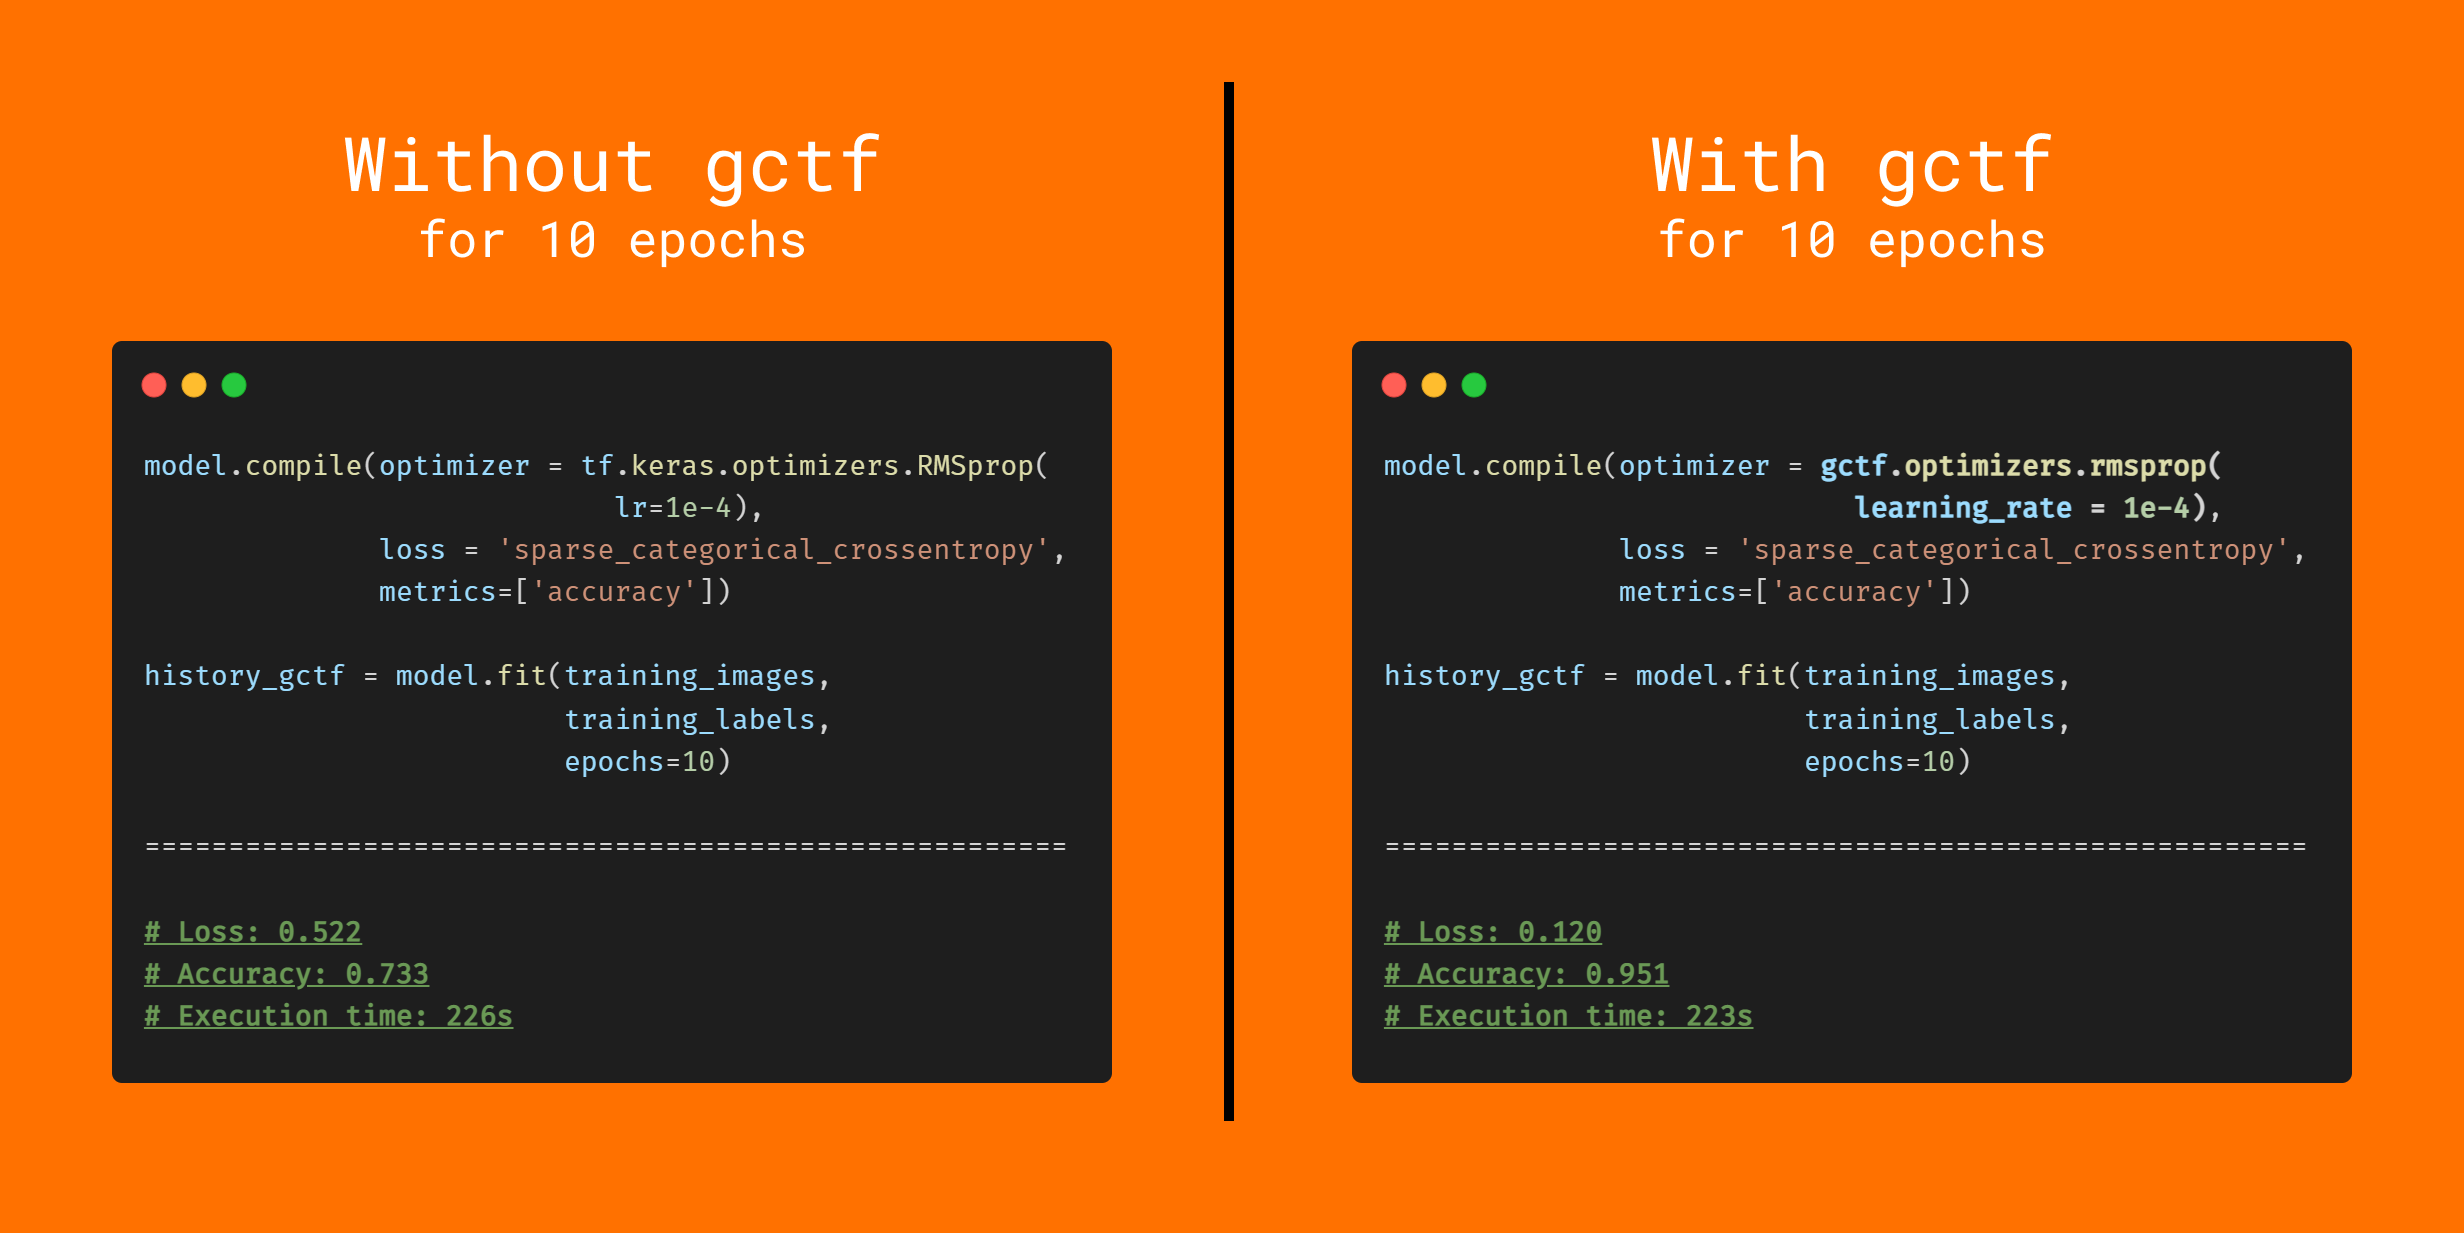


Cet exemple nécessite TensorFlow 2.2 ou version ultérieure.

In [40]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [41]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

def create_model(input_shape, n_classes, optimizer, fine_tune=0):

    conv_base = InceptionV3(classes=n_classes, weights=None, input_shape=input_shape, classifier_activation="softmax")

    conv_base.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    
    return conv_base

implémentation de Gradient Centralization :

In [42]:
import gctf

input_shape = (299, 299, 1)
optim_1 = gctf.optimizers.adam(learning_rate=0.000161803398875)
n_classes=3


# First we'll train the model without Fine-tuning
model_builder = create_model(input_shape, n_classes, optim_1, fine_tune=0)
model_builder.build(input_shape)

Nous avons aussi équilibré le jeu de données afin d'améliorer l'apprentissage et la précision.
Nous avons à peu près 1300 images de pneumonie bactérienne et 1300 de peumonie virale.
Nous avons réduit le nombre d'image de poumons normaux à 1000,
de cette façon nous espèrons obtenir plus de faux positif plutot que de faux négatif.
Un faux positif est préférable à un faux négatif dans le cas d'une assistance au diagnostique pour un médecin.

Found 3679 images belonging to 3 classes.
Found 2153 images belonging to 3 classes.


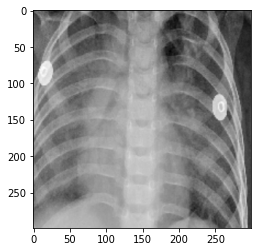

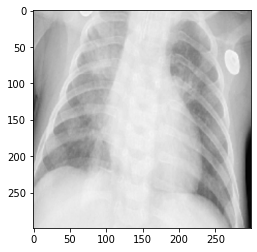

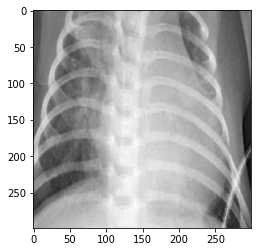

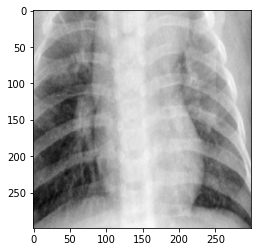

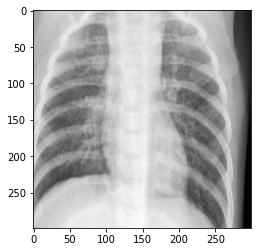

In [43]:
DIM = 299
train_datagen = ImageDataGenerator(zoom_range=[0.65, 0.8])
test_datagen = ImageDataGenerator()
batch_size = 10
training_set = train_datagen.flow_from_directory(r'C:\Users\smonn\Desktop\T8-AI&BigData_pdf\chest_Xray_3_class\train',
                                                 target_size = (DIM, DIM),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                                 color_mode="grayscale")
test_set = test_datagen.flow_from_directory(r'C:\Users\smonn\Desktop\T8-AI&BigData_pdf\chest_Xray_3_class\test',
                                            target_size = (DIM,DIM),
                                            batch_size = batch_size,
                                            class_mode = 'categorical',
                                            color_mode="grayscale")

for _ in range(5):
    img, label = training_set.next()
    #  (1,256,256,3)
    plt.imshow(img[0],cmap = plt.cm.gray)
    plt.show()

In [44]:
model_builder.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 1) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 149, 149, 32) 288         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 149, 149, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 149, 149, 32) 0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

In [20]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(filepath="gradient-centralization-2.h5", 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_best_only=True)

early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=50, verbose=1, mode='auto')

history = model_builder.fit(training_set,
                    batch_size = 100,
                    epochs = 100,
                    callbacks=[checkpoint, early],
                    validation_data = test_set,
                    validation_batch_size = 50, validation_steps=10)

Epoch 1/100
368/368 [==============================] - 41s 101ms/step - loss: 0.4683 - accuracy: 0.7855 - val_loss: 0.7434 - val_accuracy: 0.6300

Epoch 00001: val_accuracy improved from -inf to 0.63000, saving model to gradient-centralization-2.h5
Epoch 2/100
368/368 [==============================] - 37s 102ms/step - loss: 0.4314 - accuracy: 0.8038 - val_loss: 0.8853 - val_accuracy: 0.5000

Epoch 00002: val_accuracy did not improve from 0.63000
Epoch 3/100
368/368 [==============================] - 37s 102ms/step - loss: 0.4244 - accuracy: 0.8062 - val_loss: 0.9034 - val_accuracy: 0.6900

Epoch 00003: val_accuracy improved from 0.63000 to 0.69000, saving model to gradient-centralization-2.h5
Epoch 4/100
368/368 [==============================] - 38s 104ms/step - loss: 0.3943 - accuracy: 0.8304 - val_loss: 0.6177 - val_accuracy: 0.7500

Epoch 00004: val_accuracy improved from 0.69000 to 0.75000, saving model to gradient-centralization-2.h5
Epoch 5/100
368/368 [========================

368/368 [==============================] - 38s 102ms/step - loss: 0.0827 - accuracy: 0.9701 - val_loss: 0.8205 - val_accuracy: 0.8300

Epoch 00040: val_accuracy did not improve from 0.90000
Epoch 41/100
368/368 [==============================] - 38s 102ms/step - loss: 0.0820 - accuracy: 0.9690 - val_loss: 0.7268 - val_accuracy: 0.7600

Epoch 00041: val_accuracy did not improve from 0.90000
Epoch 42/100
368/368 [==============================] - 38s 102ms/step - loss: 0.0626 - accuracy: 0.9777 - val_loss: 0.8166 - val_accuracy: 0.7800

Epoch 00042: val_accuracy did not improve from 0.90000
Epoch 43/100
368/368 [==============================] - 38s 102ms/step - loss: 0.0594 - accuracy: 0.9761 - val_loss: 0.9025 - val_accuracy: 0.7400

Epoch 00043: val_accuracy did not improve from 0.90000
Epoch 44/100
368/368 [==============================] - 38s 102ms/step - loss: 0.0647 - accuracy: 0.9750 - val_loss: 0.7150 - val_accuracy: 0.7400

Epoch 00044: val_accuracy did not improve from 0.9000

In [28]:
model_builder.load_weights('gradient-centralization-2.h5')
print('gradient-centralization-2.h5')
score = model_builder.evaluate(test_set)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])
print('All: ', score)

gradient-centralization-2.h5
216/216 [==============================] - 10s 43ms/step - loss: 0.6043 - accuracy: 0.8416
Test loss:  0.6042747497558594
Test accuracy:  0.8416163325309753
All:  [0.6042747497558594, 0.8416163325309753]


In [45]:
model_builder.load_weights('gradient-centralization.h5')
print('gradient-centralization.h5')
score = model_builder.evaluate(test_set)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])
print('All: ', score)

gradient-centralization.h5
216/216 [==============================] - 11s 43ms/step - loss: 0.4198 - accuracy: 0.8611
Test loss:  0.419796347618103
Test accuracy:  0.8611240386962891
All:  [0.419796347618103, 0.8611240386962891]


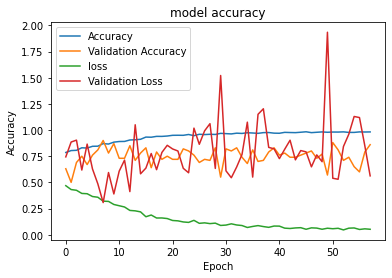

<Figure size 21600x21600 with 0 Axes>

In [23]:
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.figure(figsize=(300, 300))
plt.show()

In [46]:
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "mixed10"

In [47]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size, grayscale=True)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


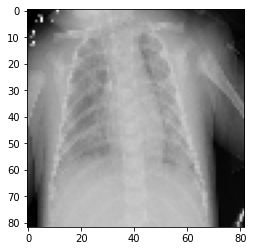

In [51]:
img_path = r"C:\Users\smonn\Desktop\T8-AI&BigData_pdf\chest_Xray_3_class\val\PNEUMONIA_BACTERIA\person1951_bacteria_4882.jpeg"

# faux positif ==> r"C:\Users\smonn\Desktop\T8-AI&BigData_pdf\chest_Xray_3_class\val\NORMAL\NORMAL2-IM-1427-0001.jpeg"

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img = cv2.resize(img, (82,82))

plt.imshow(img,cmap = plt.cm.gray)
plt.show()

Testons-le

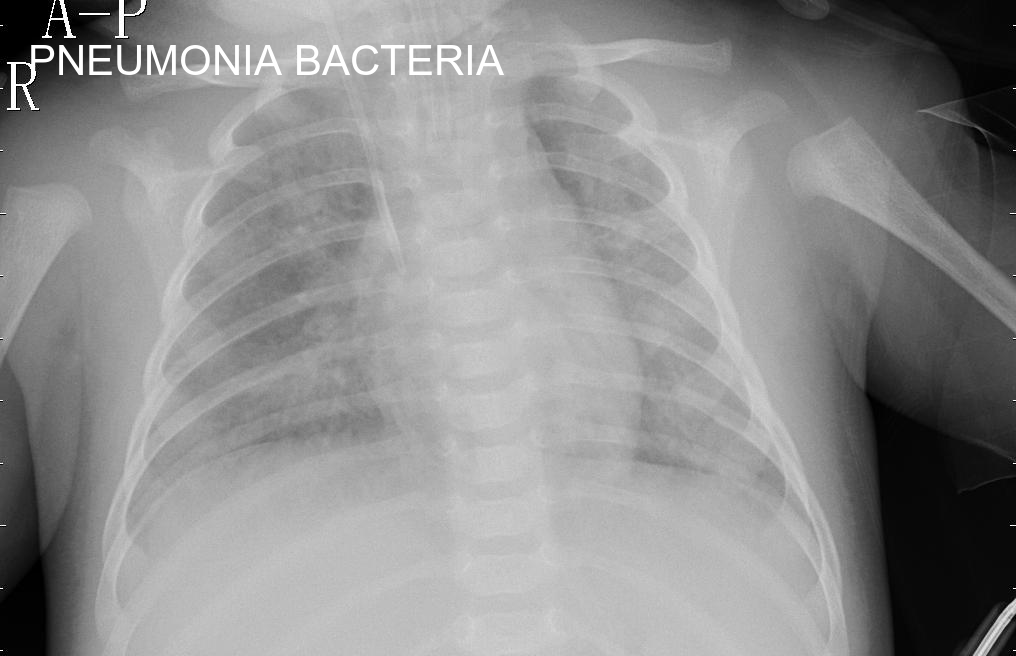

La classe prédite est : PNEUMONIA BACTERIA


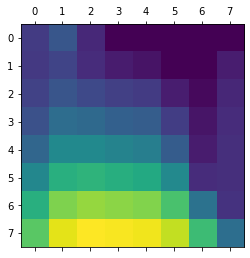

In [54]:
from tensorflow.keras.preprocessing import image

img_size = (299,299)
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)

# # img = image.load_img(ORIGINAL, target_size=(DIM, DIM))
# img = tf.keras.utils.load_img(ORIGINAL, color_mode="grayscale", target_size=(DIM, DIM))

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img = cv2.resize(img, (299,299))

# Prédiction d'images
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = np.argmax(model.predict(images, batch_size=10), axis=-1)
classe_name = ""


from PIL import Image as IM
from PIL import ImageDraw
from PIL import ImageFont

# Open an Image
img = IM.open(img_path)
 
# Call draw Method to add 2D graphics in an image
I1 = ImageDraw.Draw(img)
myFont = ImageFont.truetype("arial.ttf", 42)

if classes[0] == 0:
    classe_name = "NORMAL"
    I1.text((28, 36), classe_name, font=myFont, fill="white")

if classes[0] == 1:
    classe_name = "PNEUMONIA BACTERIA"
    I1.text((28, 36), classe_name, font=myFont, fill="white")

if classes[0] == 2:
    classe_name = "PNEUMONIA VIRUS"
    I1.text((28, 36), classe_name, font=myFont, fill="white")

img.save(classe_name+".png")

img_path2 = classe_name+".png"

from IPython.display import Image, display

display(Image(img_path2))

print("La classe prédite est :",classe_name)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

Créer une visualisation superposée

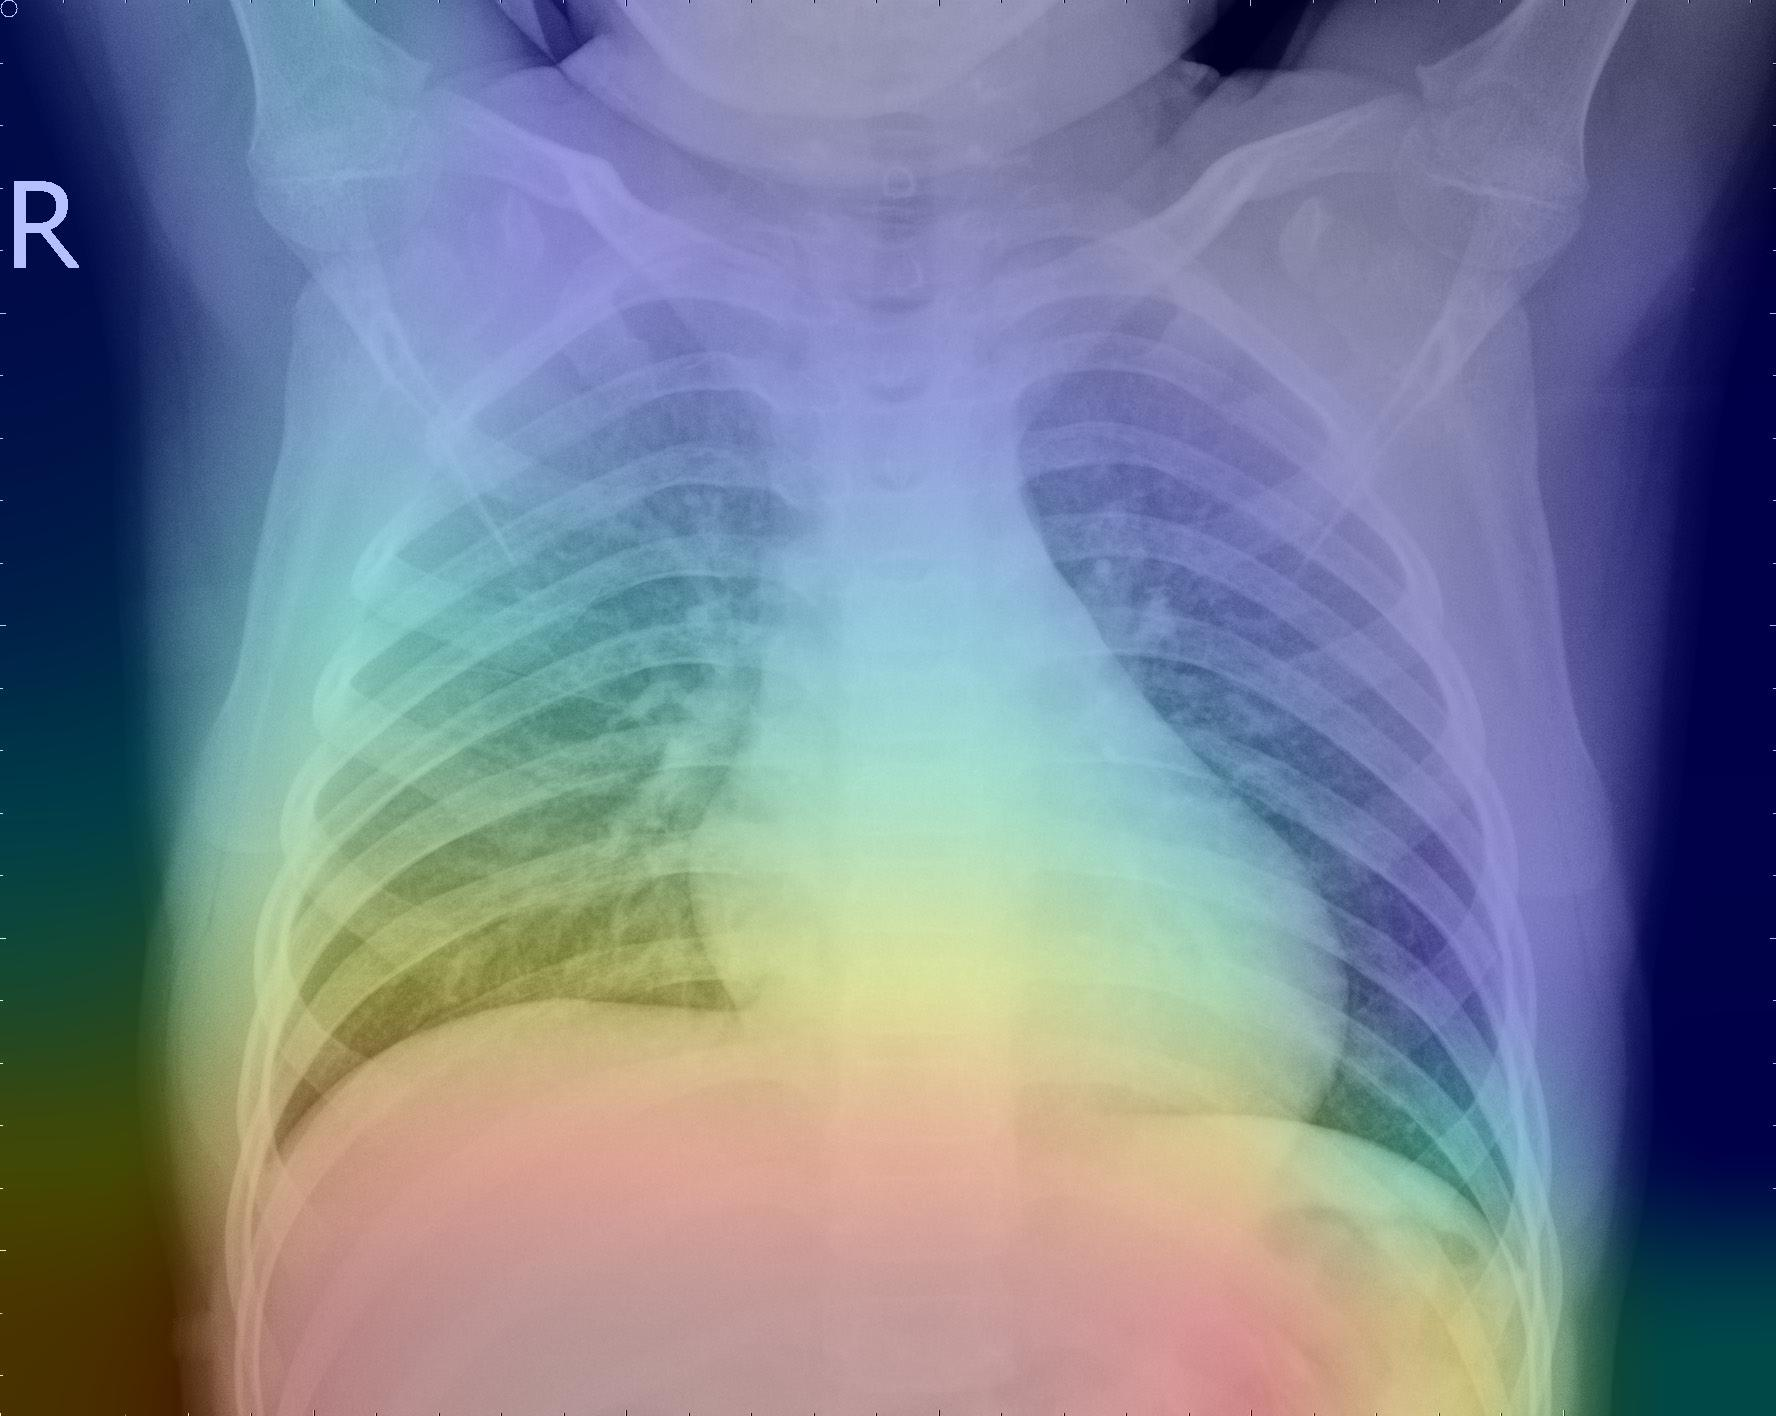

In [50]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)
    
    # Display Grad CAM

    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

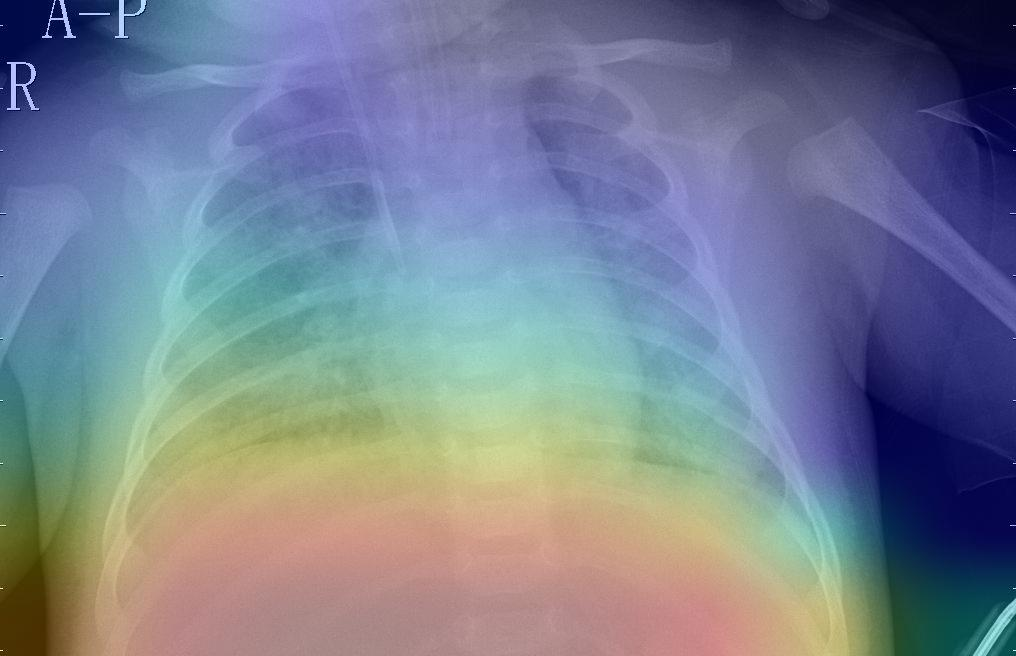

In [55]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)
    
    # Display Grad CAM

    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)